In [1]:
import pandas as pd
import numpy as np
from pylab import *
import scipy.stats as stats
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
import shap
from sklearn.ensemble import IsolationForest

In [2]:
df= pd.read_pickle("../data/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName,TimeStamp
494,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00,2019-11-07 12:29:06
2439,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00,2019-11-07 12:29:26
2515,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00,2019-11-07 12:29:26
2935,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00,2019-11-07 12:29:30
3239,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00,2019-11-07 12:29:32


In [3]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

# ML su Voltage Curve

In [82]:
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

indice del primo valore per cui l'inclinazione della curva inizia a diventare negativa
Escludere i valori precedenti a questo indice per analizzare la curva

In [83]:
#indice del primo valore per cui l'inclinazione della curva diventa negativa
#position=curva.diff()[curva.diff()==next(x for x in curva.diff() if x < 0)].index[0]
#curva_new è la curva senza il primo picco
#curva_new=curva.iloc[position:]
#plot(curva_new)

In [84]:
exploded_voltage_diff=exploded_voltage.diff(axis=1)
exploded_voltage_diff=exploded_voltage_diff.drop(columns=0,axis=1)

In [85]:
exploded_voltage_diff.iloc[:3].apply(lambda x: x.gt(0).idxmin(),axis=1)

spotName    TimeStamp          
60000_0_00  2019-11-07 12:29:06    8
            2019-11-07 12:29:26    8
            2019-11-07 12:29:26    7
dtype: int64

In [86]:
exploded_voltage_diff["posizione"]=exploded_voltage_diff.apply(lambda x: x.gt(0).idxmin(),axis=1)

In [87]:
#(exploded_voltage_diff.iloc[:3].apply(lambda x: x[x.posizione:],axis=1))

Non so come fare a rimuovere i primi n valori sulla base di posizione!!!!!

--> faccio una media di posizione arrotondata per eccesso e rimuovo le prime x=media(posizione) colonne del dataframe.

In [88]:
#math.ceil(exploded_voltage_diff.posizione.mean())

In [89]:
curve_ML=exploded_voltage.iloc[: , math.ceil(exploded_voltage_diff.posizione.mean()):]

## Estrazione Caratteristiche curve Voltage
Calcolo le caratteristiche delle curve su cui poi applicare algoritmi di ML:
- Media, Max, Min, Range, Varianza, Derivata, Curtosi...

In [90]:
curve_ML["media"]=curve_ML.iloc[:,:616].apply(mean,axis=1)
curve_ML["mediana"]=curve_ML.iloc[:,:616].apply(lambda x : median(x[x.notna()]),axis=1)
curve_ML["max"]=curve_ML.iloc[:,:616].apply(max,axis=1)
curve_ML["min"]=curve_ML.iloc[:,:616].apply(min,axis=1)
curve_ML["varianza"]=curve_ML.iloc[:,:616].apply(var,axis=1)

In [91]:
curve_ML["mediana"]=curve_ML.iloc[:,:616].apply(lambda x : median(x[x.notna()]),axis=1)

In [92]:
#lunghezza come numero di valori non Null
curve_ML["lunghezza"]=curve_ML.iloc[:,:616].apply(lambda x: len(x[x.notna()]),axis=1)

In [93]:
#range intesa come max-min
curve_ML["range"]=curve_ML.iloc[:,:616].apply(lambda x: x.max()-x.min(),axis=1)

In [94]:
#calcolo della derivata come delta(y)/delta(x): ovvero range/lunghezza lista
curve_ML["derivata"]=curve_ML.apply(lambda x: x.range/len(x[:616][x[:616].notna()]),axis=1)

In [95]:
#curtosi
curve_ML["kurtosis"]=curve_ML.iloc[:,:616].apply(lambda x: kurtosis(x[x.notna()]),axis=1)

In [96]:
final_ML=curve_ML.iloc[:,616:]
final_ML.head()

media  mediana     max     min  \
spotName   TimeStamp                                                   
60000_0_00 2019-11-07 12:29:06  1475.613281   1249.0  2085.0  1199.0   
           2019-11-07 12:29:26  1691.521635   1624.0  2180.0  1393.0   
           2019-11-07 12:29:26  1683.105392   1622.0  2099.0  1383.0   
           2019-11-07 12:29:30  1657.260143   1603.0  2129.0  1353.0   
           2019-11-07 12:29:32  1696.208738   1639.5  2155.0  1399.0   

                                     varianza  lunghezza  range  derivata  \
spotName   TimeStamp                                                        
60000_0_00 2019-11-07 12:29:06  106775.116074        512  886.0  1.730469   
           2019-11-07 12:29:26   56225.182224        416  787.0  1.891827   
           2019-11-07 12:29:26   47841.104089        408  716.0  1.754902   
           2019-11-07 12:29:30   53271.247361        419  776.0  1.852029   
           2019-11-07 12:29:32   51611.204001        412  756.0  1.834951   

                                kurtosis  
spotName   TimeStamp                      
60000_0_00 2019-11-07 12:29:06 -1.339670  
           2019-11-07 12:29:26 -1.110572  
           2019-11-07 12:29:26 -1.325995  
           2019-11-07 12:29:30 -1.196977  
           2019-11-07 12:29:32 -1.182049

In [ ]:
final_ML.to_pickle("../data/volt_ML.pkl")

## Feature Engineering

In [4]:
final_ML= pd.read_pickle("../data/volt_ML.pkl")  

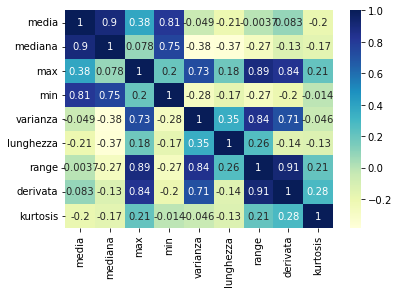

In [3]:
ax=sns.heatmap(final_ML.corr(),annot=True,cmap="YlGnBu")

In [5]:
dummy=final_ML.drop(["media","range","max","min","varianza"],axis=1)

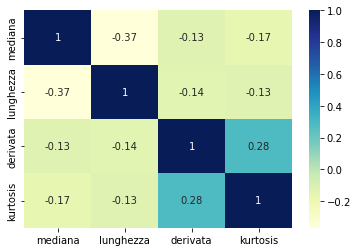

In [5]:
ax=sns.heatmap(dummy.corr(),annot=True,cmap="YlGnBu")

#### Split train & test set
Essendo un problema non supervisionato opero un random holdhout per la creazione di train e test set.

In [6]:
df_train, df_test=train_test_split(dummy,train_size=0.8,shuffle=True,random_state=0)

## Isolation Forest

In [7]:
iso = IsolationForest(contamination=0.2)
yhat_iForest = iso.fit_predict(df_train)

X does not have valid feature names, but IsolationForest was fitted with feature names


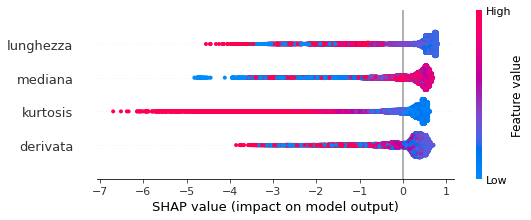

In [54]:
shap_values = shap.TreeExplainer(iso).shap_values(df_test)
shap.summary_plot(shap_values, df_test)

## Minimum Covariance Determinant

In [59]:
ee = EllipticEnvelope(contamination=0.01)
yhat__ee = ee.fit_predict(df_train)

## Aggiungo colonne delle varie yhat al df

In [129]:
len(df_train)

113336

In [8]:
df_train["iForest"]=yhat_iForest

In [9]:
df_train[df_train["iForest"]==-1]

mediana  lunghezza  derivata  kurtosis  \
spotName   TimeStamp                                                     
60022_0_00 2020-02-12 11:04:50   1455.0        430  2.569767  2.324861   
           2020-03-04 18:43:45   1495.0        392  2.905612  1.958150   
60026_0_00 2020-02-24 18:20:47   1517.0        512  1.722656  1.128983   
60168_0_00 2020-02-19 11:42:01   1592.0        292  1.541096 -0.442702   
60028_0_00 2020-01-09 10:23:49   1396.0        564  1.278369  0.856953   
...                                 ...        ...       ...       ...   
60030_0_00 2020-02-13 07:29:16   1305.0        551  1.117967 -0.258504   
60077_0_00 2020-01-15 12:40:55   1197.0        512  1.445312  0.018491   
60166_0_00 2020-03-12 15:46:18   1527.0        306  2.313725  5.447741   
60180_0_00 2020-02-25 17:09:03   1658.0        392  0.619898  0.352064   
60141_0_00 2019-12-19 09:56:48   1252.5        392  1.982143 -1.612149   

                                iForest  
spotName   TimeStamp                     
60022_0_00 2020-02-12 11:04:50       -1  
           2020-03-04 18:43:45       -1  
60026_0_00 2020-02-24 18:20:47       -1  
60168_0_00 2020-02-19 11:42:01       -1  
60028_0_00 2020-01-09 10:23:49       -1  
...                                 ...  
60030_0_00 2020-02-13 07:29:16       -1  
60077_0_00 2020-01-15 12:40:55       -1  
60166_0_00 2020-03-12 15:46:18       -1  
60180_0_00 2020-02-25 17:09:03       -1  
60141_0_00 2019-12-19 09:56:48       -1  

[22667 rows x 5 columns]

## Plot per valutare curve anomale
Le curve anomale rilevate sembrerebbero essere quelle con i cali anomali, sia attraverso drop repentini che cali più graduali ma precoci rispetto alla media

***L'algoritmo di ML avrà un bias per i cali rispetto ai picchi poichè i cali repentini rappresentano l'anomalia più evidente e diffusa del processo !!***

I processi con i cali più graduali spesso non vengono identificati da anomaly_drop ma sono caratterizzati da un alto valore di %volt_anomalies

In [26]:
df.VoltageCurve

In [ ]:
60166_0_00	2020-03-12 15:46:18

In [11]:
df= pd.read_pickle("../data/with_stat_anomalies.pkl")  

In [15]:
df.loc[('60166_0_00', '2020-03-12 15:46:18'), :]

,VoltageCurve,CurrentCurve,voltage_drop,voltage_spike,n_voltage_outliers,%volt_anomalies,n_current_outliers,%current_anomalies
TimeStamp,,,,,,,,
2020-03-12 15:46:18,"[144, 795, 1334, 1656, 1849, 1977, 2009, 1993,...","[326, 2185, 3980, 5187, 6035, 6688, 6981, 7112...",False,False,171,54.458599,8,2.547771


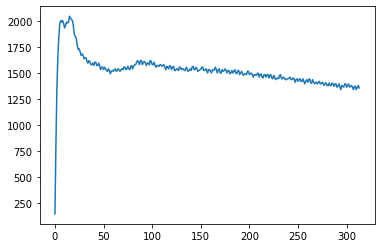

In [16]:
curva=df.loc[('60166_0_00', '2020-03-12 15:46:18'), :].VoltageCurve
plot(curva.values[0])